# Описание проекта
--- 
> Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

>  **Описание тарифов**

> **Тариф «Смарт»**
1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
•	минута разговора: 3 рубля
•	сообщение: 3 рубля
•	1 Гб интернет-трафика: 200 рублей

> **Тариф «Ультра»**
1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
•	минута разговора: 1 рубль
•	сообщение: 1 рубль
•	1 Гб интернет-трафика: 150 рублей
> Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.</div>

# Описание данных
--- 

> **Таблица users (информация о пользователях):**
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

> **Таблица calls (информация о звонках):**
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

> **Таблица messages (информация о сообщениях):**
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

> **Таблица internet (информация об интернет-сессиях):**
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

> **Таблица tariffs (информация о тарифах):**
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

> *Примечание. Если объединение таблиц методом merge приводит к ошибке dead kernell, примените метод join — это облегчит нагрузку на Jupyter Notebook.*


# Оглавление
--- 

> - [Открытие данных](#id-open) 
- [Подготовка данных](#id-dataprep) 
- [Анализ](#id-analysis) 
- [Проверка гипотез](#id-hypothesis)
- [Главный вывод](#id-conclusion)

# Шаг 1. Открытие и изучение файлов <a id="id-open"></a>
--- 

> Откройте файл с данными и изучите общую информацию.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats as st
import math
from scipy.stats import bartlett

In [2]:
calls = pd.read_csv("/datasets/calls.csv")
internet = pd.read_csv("/datasets/internet.csv")
messages = pd.read_csv("/datasets/messages.csv")
tariffs = pd.read_csv("/datasets/tariffs.csv")
users = pd.read_csv("/datasets/users.csv")

In [3]:
calls.sample(5)

,id,call_date,duration,user_id
200709,1495_96,2018-08-30,6.97,1495
137091,1350_221,2018-11-15,12.33,1350
13618,1035_305,2018-12-06,0.00,1035
136274,1347_86,2018-12-23,0.00,1347
64734,1167_185,2018-11-13,4.63,1167


In [4]:
internet.sample(5)

,Unnamed: 0,id,mb_used,session_date,user_id
108502,108502,1370_307,206.74,2018-05-15,1370
6187,6187,1019_118,723.43,2018-08-14,1019
24983,24983,1086_190,289.42,2018-11-25,1086
7677,7677,1027_4,0.00,2018-10-17,1027
149123,149123,1498_116,782.43,2018-07-20,1498


In [5]:
messages.sample(5)

,id,message_date,user_id
65623,1282_55,2018-11-24,1282
13072,1055_38,2018-11-28,1055
93517,1385_226,2018-02-02,1385
73356,1310_225,2018-12-19,1310
116099,1472_403,2018-02-17,1472


In [6]:
tariffs.sample(2)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
1,1000,30720,3000,1950,150,1,1,ultra
0,50,15360,500,550,200,3,3,smart


In [7]:
users.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
154,1154,19,NaN,Волжский,Марина,Тихомирова,2018-06-02,smart
400,1400,71,NaN,Москва,Ренат,Артёмов,2018-08-24,smart
422,1422,60,2018-12-21,Москва,Клара,Устинова,2018-10-12,smart
296,1296,60,NaN,Москва,Альфред,Черный,2018-06-05,smart
160,1160,73,NaN,Ульяновск,Борис,Авдонюшкин,2018-07-03,smart


In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [11]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [13]:
calls.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0


In [14]:
internet.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,149396.0,74697.500000,43127.054745,0.0,37348.7500,74697.500,112046.2500,149395.00
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83
user_id,149396.0,1252.099842,144.050823,1000.0,1130.0000,1251.000,1380.0000,1499.00


In [15]:
messages.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,123036.0,1256.98941,143.523967,1000.0,1134.0,1271.0,1381.0,1499.0


In [16]:
tariffs.describe().T

,count,mean,std,min,25%,50%,75%,max
messages_included,2.0,525.0,671.751442,50.0,287.5,525.0,762.5,1000.0
mb_per_month_included,2.0,23040.0,10861.160159,15360.0,19200.0,23040.0,26880.0,30720.0
minutes_included,2.0,1750.0,1767.766953,500.0,1125.0,1750.0,2375.0,3000.0
rub_monthly_fee,2.0,1250.0,989.949494,550.0,900.0,1250.0,1600.0,1950.0
rub_per_gb,2.0,175.0,35.355339,150.0,162.5,175.0,187.5,200.0
rub_per_message,2.0,2.0,1.414214,1.0,1.5,2.0,2.5,3.0
rub_per_minute,2.0,2.0,1.414214,1.0,1.5,2.0,2.5,3.0


In [17]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,46.588,16.667630,18.0,32.00,46.0,62.00,75.0


### Вывод

Первый взгляд на исходные данные показал следующее:
- 5 таблиц;
- В таблице internet колонку Unnamed: 0 можно дропнуть;
- Пустые значения есть только в колонке churn, но они объясняются в описании задания;
- Есть колонки id/user_id, по которым можно объединить таблицы;
- В колонке длительность звонков минимальная длительность = 0, что странно с учетом того, что округление у Мегалайна до минуты, надо изучить дополнительно этот момент;
- Надо привести типы данных к нужным форматам. 

# Шаг 2. Подготовьте данные<a id="id-dataprep"></a>
--- 

> - Приведите данные к нужным типам;
- Найдите и исправьте ошибки в данных.

> Поясните, какие ошибки вы нашли и как их исправили. Обратите внимание, что длительность многих звонков — 0.0 минут. Это могут быть пропущенные звонки. Обрабатывать ли эти нулевые значения, решать вам — оцените, как их отсутствие повлияет на результаты анализа.

> Посчитайте для каждого пользователя:

> - количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

## Приведение данных в нужный вид

In [18]:
len(calls.query("duration == 0"))/len(calls)

0.19551644316336553

20% значений duration равны нулю, скорее всего это пропущенные звонки. Это большой объем информации, который не надо терять. Строки с нулевыми значения в длительности звонка могут содержать информацию о израсходованном трафике, сообщениях и пр. Удаление строк может повлиять на общую сумму выручки. Поэтому оставим все как есть.

Приведем даты к формату даты и изучим распределение остальных колонок.

In [19]:
calls['call_date'] = pd.to_datetime(calls['call_date'],format='%Y-%m-%d')

In [20]:
calls["duration"] = calls["duration"].apply(math.ceil)

Обрежем нулевые значения на гистограмме, так как их слишком много и они мешают оценить распределение значений длительности 

Text(0, 0.5, 'Количество значений')

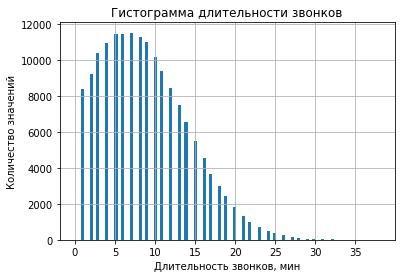

In [21]:
ax = calls['duration'].hist(bins=100, range=(0.0001, max(calls['duration'])));
ax.set_title("Гистограмма длительности звонков")
ax.set_xlabel("Длительность звонков, мин")
ax.set_ylabel("Количество значений")

Пик длительности звонков приходится на диапазон примерно от 4 до 7 минут. Распределение скошено вправо, но значений в правом хвосте не так много. В нашей выборке пользователи редко разговаривают по телефону более 20 минут.

In [22]:
internet = internet.drop("Unnamed: 0", axis = 1)

In [23]:
internet["mb_used"] = internet["mb_used"].apply(math.ceil)

In [24]:
internet['session_date'] = pd.to_datetime(internet['session_date'],format='%Y-%m-%d')

Text(0, 0.5, 'Количество значений')

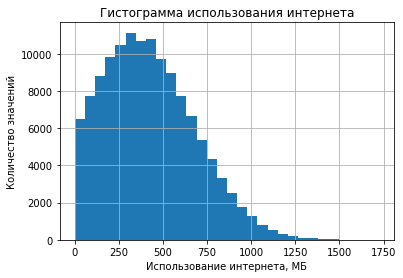

In [25]:
ax = internet["mb_used"].hist(bins=30, range=(0.0001, max(internet["mb_used"])));
ax.set_title("Гистограмма использования интернета")
ax.set_xlabel("Использование интернета, МБ")
ax.set_ylabel("Количество значений")

Пик использованных мб приходится на диапазон примерно от 260 до 490 МБ. Распределение скошено вправо, но значений в правом хвосте не так много. В нашей выборке пользователи редко используют больше 1000 мб за сессию.

In [26]:
messages['message_date'] = pd.to_datetime(messages['message_date'],format='%Y-%m-%d')

In [27]:
users["reg_date"] = pd.to_datetime(users['reg_date'],format='%Y-%m-%d')

Text(0, 0.5, 'Количество значений')

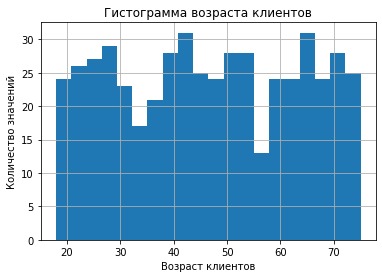

In [28]:
ax = users["age"].hist(bins=20);
ax.set_title("Гистограмма возраста клиентов")
ax.set_xlabel("Возраст клиентов")
ax.set_ylabel("Количество значений")

В выборке есть пользователи всех возрастов от 18 лет. Для каждого возраста у нас имеется не менее 10 пользователей.

In [29]:
users["churn_date"] = pd.to_datetime(users['churn_date'],format='%Y-%m-%d')

In [30]:
users["churn_date"].isna().sum()

462

Заполним пустые значения churn_date какой-нибудь датой из будущего для обработки пустых значений.

In [31]:
users["churn_date"] = users["churn_date"].fillna(pd.Timestamp(2021, 1, 1))

In [32]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    500 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


## Создадим таблицу-отчет, в котрой соберем и посчитаем все необходимые нам данные

Создадим колонку "месяц" в таблицах с датами.

In [33]:
calls['reg_month'] = calls['call_date'].values.astype('datetime64[M]')

In [34]:
users['reg_month'] = users['reg_date'].values.astype('datetime64[M]')

In [35]:
messages['reg_month'] = messages['message_date'].values.astype('datetime64[M]')

In [36]:
internet["reg_month"] = internet['session_date'].values.astype('datetime64[M]')

Создадим таблицу уникальных пользователей и таблицу месяцев, закроссджойним эти таблицы, чтобы затем к ним присоединять наши исходные данные.

Создаем таблицу  месяцев.

In [37]:
min_month = users['reg_month'].values.astype('datetime64[M]').min()

In [38]:
max_month = users['reg_month'].values.astype('datetime64[M]').max()

In [39]:
dr = pd.DataFrame(pd.date_range(min_month,max_month,freq='MS'))

In [40]:
dr

,0
0,2018-01-01
1,2018-02-01
2,2018-03-01
3,2018-04-01
4,2018-05-01
5,2018-06-01
6,2018-07-01
7,2018-08-01
8,2018-09-01
9,2018-10-01


In [41]:
dr.columns = ['reg_month']

In [42]:
dr['key'] = 1

Создаем таблицу уникальных пользователей.

In [43]:
user = users.groupby(['user_id'])['reg_month',"tariff", "city"].min().reset_index()

In [44]:
user.drop("reg_month", axis=1, inplace=True)

In [45]:
user['key'] = 1

Кроссджойним эти таблицы.

In [46]:
report = dr.merge(user,on='key')

In [47]:
report.query("user_id == 1000")

,reg_month,key,user_id,tariff,city
0,2018-01-01,1,1000,ultra,Краснодар
500,2018-02-01,1,1000,ultra,Краснодар
1000,2018-03-01,1,1000,ultra,Краснодар
1500,2018-04-01,1,1000,ultra,Краснодар
2000,2018-05-01,1,1000,ultra,Краснодар
2500,2018-06-01,1,1000,ultra,Краснодар
3000,2018-07-01,1,1000,ultra,Краснодар
3500,2018-08-01,1,1000,ultra,Краснодар
4000,2018-09-01,1,1000,ultra,Краснодар
4500,2018-10-01,1,1000,ultra,Краснодар


Дальше по каждой таблице исходных данных сделаем группировку по месяцу и присоединим сгруппированную таблицу к нашей заготовке report.

Для каждой таблицы будем проверять тотал в исходной таблице и в итоговой таблице report, чтобы все билось.

Присоединяем calls.

In [48]:
calls["duration"].sum()

1450301

In [49]:
calls_month = calls.groupby(['user_id','reg_month'])['duration'].agg(['sum']).reset_index()

In [50]:
calls_month.columns = ["user_id", "reg_month","calls_duration"]

In [51]:
calls_month_count = calls.groupby(['user_id','reg_month'])['id'].agg(['count']).reset_index()

In [52]:
calls_month_count.columns = ["user_id", "reg_month","calls_count"]

In [53]:
calls_month_count["calls_count"].sum()

202607

In [54]:
report = report.merge(calls_month,how='left',on=['user_id','reg_month'])

In [55]:
report = report.merge(calls_month_count,how='left',on=['user_id','reg_month'])

In [56]:
report["calls_duration"].sum()

1450301.0

In [57]:
report["calls_count"].sum()

202607.0

Присоединяем internet.

In [58]:
internet["mb_used"].sum()

55369459

In [59]:
internet_month = internet.groupby(['user_id','reg_month'])['mb_used'].agg(['sum']).reset_index()

In [60]:
internet_month.columns = ["user_id", "reg_month","internet_mb_used"]

In [61]:
report = report.merge(internet_month,how='left',on=['user_id','reg_month'])

In [62]:
report["internet_mb_used"].sum()

55369459.0

Присоединяем messages.

In [63]:
messages_month = messages.groupby(['user_id','reg_month'])['id'].agg(['count']).reset_index()

In [64]:
messages_month.columns = ["user_id", "reg_month","messages_count"]

In [65]:
messages_month["messages_count"].sum()

123036

In [66]:
report = report.merge(messages_month,how='left',on=['user_id','reg_month'])

In [67]:
report["messages_count"].sum()

123036.0

Присоединяем информацию по тарифам. Если бы выборка была больше, я бы так не делала с точки зрения производительности и экономии памяти. Но так как наблюдений у нас всего 6000, а переменных 15 для удобства объединим все в одной таблице.

In [68]:
tariffs.columns = ['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff']

In [69]:
report = report.merge(tariffs, how='left', on="tariff")

Заполним пустые значения нулями. Если у абонента пустое значение длительности звонка/использованного интернета/сообщений, значит их не было в этом месяце, значит 0. Заполнение нулями будет удобно для дальнейших расчетов.

In [70]:
report = report.fillna(0)

Рассчитаем выручку, которую телекомпании принесли клиенты, которые пользовались услугами сверх тарифа

In [71]:
report

,reg_month,key,user_id,tariff,city,calls_duration,calls_count,internet_mb_used,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,2018-01-01,1,1000,ultra,Краснодар,0.0,0.0,0.0,0.0,1000,30720,3000,1950,150,1,1
1,2018-01-01,1,1001,smart,Москва,0.0,0.0,0.0,0.0,50,15360,500,550,200,3,3
2,2018-01-01,1,1002,smart,Стерлитамак,0.0,0.0,0.0,0.0,50,15360,500,550,200,3,3
3,2018-01-01,1,1003,ultra,Москва,0.0,0.0,0.0,0.0,1000,30720,3000,1950,150,1,1
4,2018-01-01,1,1004,ultra,Новокузнецк,0.0,0.0,0.0,0.0,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2018-12-01,1,1495,ultra,Иркутск,1031.0,155.0,23450.0,84.0,1000,30720,3000,1950,150,1,1
5996,2018-12-01,1,1496,smart,Вологда,518.0,80.0,20757.0,51.0,50,15360,500,550,200,3,3
5997,2018-12-01,1,1497,smart,Челябинск,545.0,71.0,19940.0,17.0,50,15360,500,550,200,3,3
5998,2018-12-01,1,1498,smart,Владикавказ,0.0,0.0,0.0,0.0,50,15360,500,550,200,3,3


In [72]:
def extra_fee(report):
    internet = ((report["internet_mb_used"] - report["mb_per_month_included"])/1024).apply(math.ceil).apply(lambda x: 0 if x < 0 else x) * report["rub_per_gb"]
    minutes = (report["calls_duration"] - report["minutes_included"]).apply(lambda x: 0 if x < 0 else x) * report["rub_per_minute"]
    messages = (report["messages_count"] - report["messages_included"]).apply(lambda x: 0 if x < 0 else x) * report["rub_per_message"]
    extra_fee = internet + minutes + messages
    return extra_fee

In [73]:
report["extra_fee"] = extra_fee(report)

In [74]:
report["revenue"] = report["extra_fee"] + report["rub_monthly_fee"]

Посчитаем, что у нас получилось по выручке.

In [75]:
report["revenue"].sum()

7582251.0

In [76]:
report.query("tariff == 'smart'")["revenue"].sum()/report["revenue"].sum()

0.5244354216181976

In [77]:
report["extra_fee"].sum()/report["revenue"].sum()

0.23463362001600843

In [78]:
report.query("tariff == 'smart'")["extra_fee"].sum()/report["extra_fee"].sum()

0.9329698811332559

## Вывод

- Строки с нулевой длительностью звонков отбрасывать не стали - их слишком много и их удаление приведет к потере информации. 
- Распределения количества звонков и использованных мегабайт унимодальны, имеют скошенность вправо.
- Создали таблицу-отчет, с помощью которой в дальнейшем будем делать выводы.
- Общая выручка по пользователям за год составила 7 582 251.
- Выручка по тарифам на первый взгляд различается слабо, тариф smart приносит 52% общей выручки. Будем изучать различие между тарифами в следующих шагах.
- Плата за дополнительные услуги составляет 23% выручки. Интересно, что основную часть этой платы вносят пользователи тарифа smart - 93%.

# Шаг 3. Проанализируйте данные<a id="id-analysis"></a>
--- 

> Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

Посчитаем минуты разговора, сообщения и объем трафика на пользователя в месяц.

In [79]:
report_pivot = report.pivot_table(index = ["tariff", "reg_month"], values = ["calls_duration", "messages_count", "internet_mb_used"], 
                   aggfunc="sum").reset_index()

In [80]:
report_pivot

,tariff,reg_month,calls_duration,internet_mb_used,messages_count
0,smart,2018-01-01,6931.0,289831.0,620.0
1,smart,2018-02-01,17324.0,673461.0,1397.0
2,smart,2018-03-01,30034.0,1164537.0,2453.0
3,smart,2018-04-01,41119.0,1509702.0,3443.0
4,smart,2018-05-01,54618.0,2231353.0,4762.0
5,smart,2018-06-01,64885.0,2593622.0,5478.0
6,smart,2018-07-01,82079.0,3168466.0,6784.0
7,smart,2018-08-01,99045.0,3908561.0,7905.0
8,smart,2018-09-01,111439.0,4244377.0,8746.0
9,smart,2018-10-01,125284.0,4932898.0,9927.0


Таблица это хорошо, но не видна динамика, построим диаграммы

In [81]:
report_pivot_smart = report_pivot.query("tariff == 'smart'").set_index("reg_month")
report_pivot_ultra = report_pivot.query("tariff == 'ultra'").set_index("reg_month")

In [82]:
cols = ['calls_duration', 'internet_mb_used', 'messages_count']

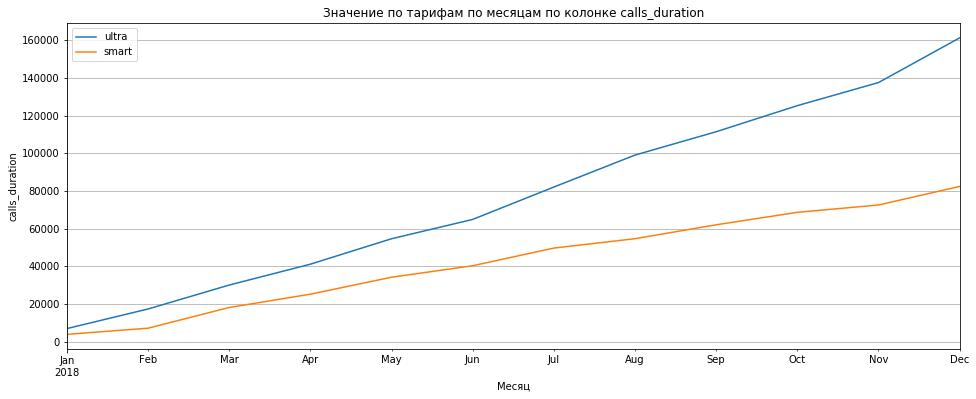

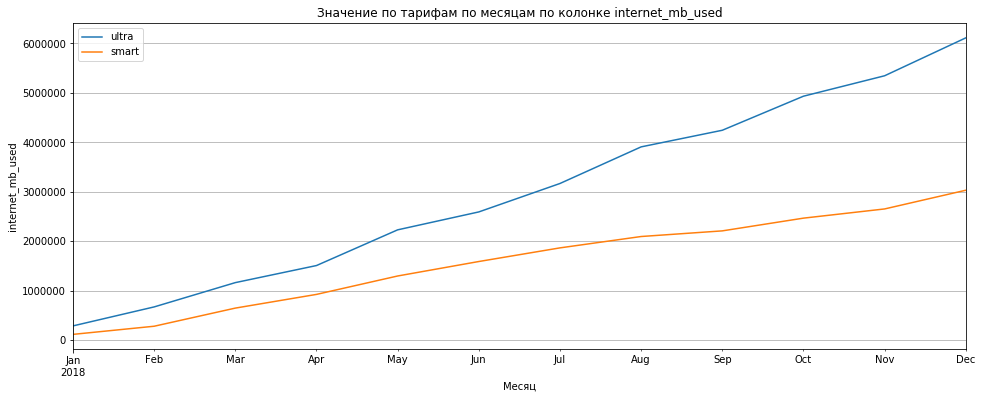

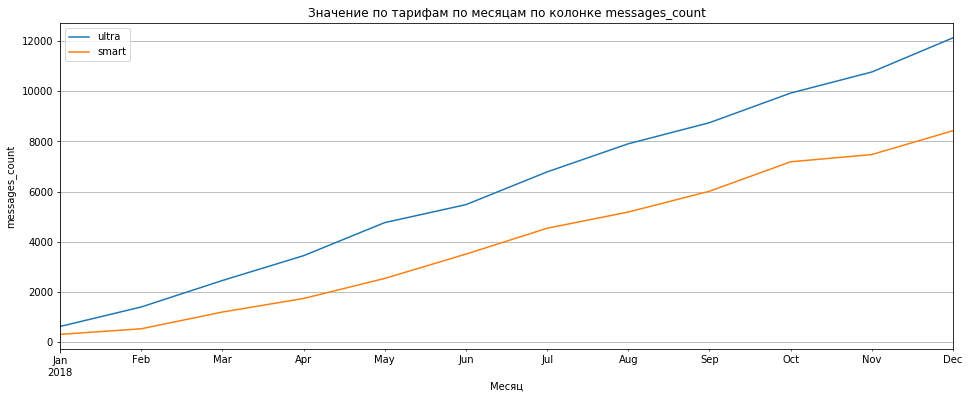

In [83]:
for i in cols: 
    figure(num=None, figsize=(16, 6), facecolor='w', edgecolor='k')
    report_pivot_smart[i].plot()
    report_pivot_ultra[i].plot()
    plt.title("Значение по тарифам по месяцам по колонке {}".format(i))
    plt.xlabel("Месяц")
    plt.ylabel(i)
    plt.legend(["ultra", "smart"])
    plt.grid(True)
    plt.show()

Пользователи тарифа ultra активнее пользутся услугами связи, интернета и сообщений по месяцам. Также по обоим тарифам наблюдается восходящий тренд с течением времени. Разрыв между тарифами увеличивается к окночанию года, в начале года разница не такая большая.

Посчитаем среднее, стандартное отклонение и дисперсию.

In [84]:
report_pivot_aggtotal = report.pivot_table(index = "tariff", values = ["calls_duration", "messages_count", "internet_mb_used"], 
                   aggfunc=[np.mean, np.var, np.std]).reset_index().T

In [85]:
report_pivot_aggtotal

0            1
tariff                         smart        ultra
mean   calls_duration        221.172      290.114
       internet_mb_used      8588.52      10735.2
       messages_count        17.6669      27.1941
var    calls_duration        62692.1       124198
       internet_mb_used  8.39155e+07  1.50134e+08
       messages_count        699.325      1861.58
std    calls_duration        250.384      352.418
       internet_mb_used      9160.54      12252.9
       messages_count        26.4448       43.146

In [86]:
report

,reg_month,key,user_id,tariff,city,calls_duration,calls_count,internet_mb_used,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,extra_fee,revenue
0,2018-01-01,1,1000,ultra,Краснодар,0.0,0.0,0.0,0.0,1000,30720,3000,1950,150,1,1,0.0,1950.0
1,2018-01-01,1,1001,smart,Москва,0.0,0.0,0.0,0.0,50,15360,500,550,200,3,3,0.0,550.0
2,2018-01-01,1,1002,smart,Стерлитамак,0.0,0.0,0.0,0.0,50,15360,500,550,200,3,3,0.0,550.0
3,2018-01-01,1,1003,ultra,Москва,0.0,0.0,0.0,0.0,1000,30720,3000,1950,150,1,1,0.0,1950.0
4,2018-01-01,1,1004,ultra,Новокузнецк,0.0,0.0,0.0,0.0,1000,30720,3000,1950,150,1,1,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2018-12-01,1,1495,ultra,Иркутск,1031.0,155.0,23450.0,84.0,1000,30720,3000,1950,150,1,1,0.0,1950.0
5996,2018-12-01,1,1496,smart,Вологда,518.0,80.0,20757.0,51.0,50,15360,500,550,200,3,3,1257.0,1807.0
5997,2018-12-01,1,1497,smart,Челябинск,545.0,71.0,19940.0,17.0,50,15360,500,550,200,3,3,1135.0,1685.0
5998,2018-12-01,1,1498,smart,Владикавказ,0.0,0.0,0.0,0.0,50,15360,500,550,200,3,3,0.0,550.0


In [87]:
messages_users = messages.merge(users,how='left',on=['user_id'])

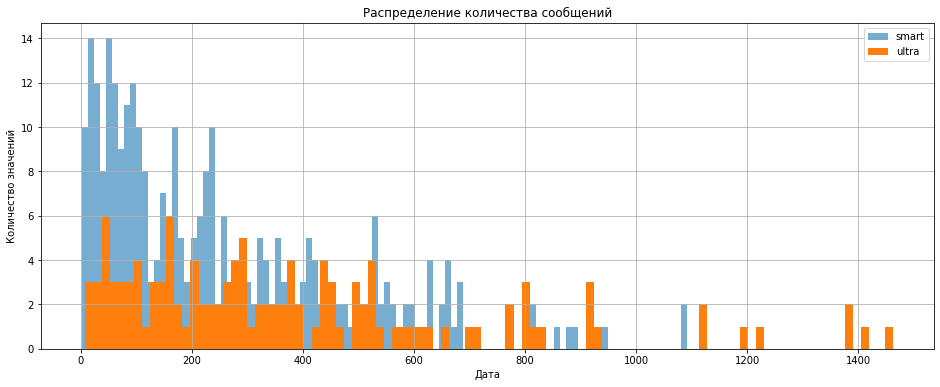

In [88]:
figure(num=None, figsize=(16, 6), facecolor='w', edgecolor='k')
messages_users.groupby(['user_id', "tariff"])['message_date'].agg(['count']).reset_index().query("tariff == 'smart'")\
["count"].hist(alpha=0.6, bins=100)
messages_users.groupby(['user_id', "tariff"])['message_date'].agg(['count']).reset_index().query("tariff == 'ultra'")\
["count"].hist(bins=100)
plt.title("Распределение количества сообщений")
plt.xlabel("Дата")
plt.ylabel("Количество значений")
plt.legend(["smart", "ultra"])
plt.grid(True)
plt.show()

Распределение количества сообщений по пользователям по обоим тарифам скошено вправо. Пик по тарифу smart находится в промежутке от нуля до 100 сообщений, ярко выраженных пиков в тарифе ultra не наблюдается. 

In [89]:
calls_users = calls.merge(users,how='left',on=['user_id'])

In [90]:
calls_users.shape

(202607, 13)

In [91]:
len(calls_users.query("tariff == 'ultra'"))/len(calls_users)

0.35680899475338956

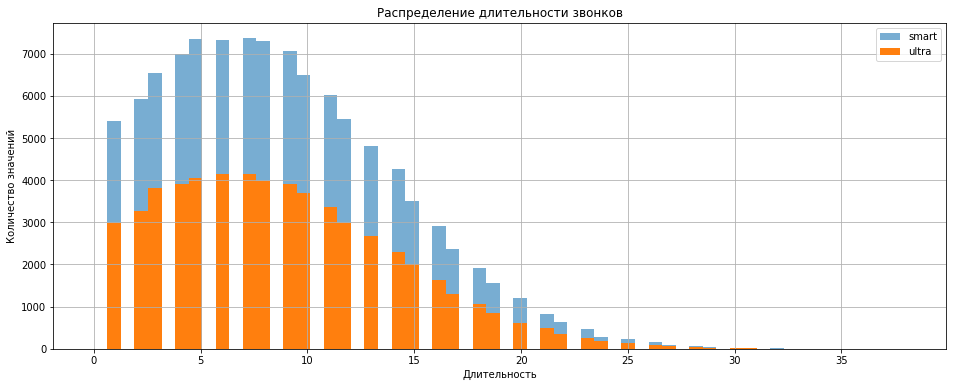

In [92]:
figure(num=None, figsize=(16, 6), facecolor='w', edgecolor='k')
calls_users.query("tariff == 'smart'")["duration"].hist(alpha=0.6, bins=60, range=(0.001, max(calls_users["duration"])))
calls_users.query("tariff == 'ultra'")["duration"].hist(bins=60, range=(0.001, max(calls_users["duration"])))
plt.title("Распределение длительности звонков")
plt.xlabel("Длительность")
plt.ylabel("Количество значений")
plt.legend(["smart", "ultra"])
plt.grid(True)
plt.show()

Распределения длительности звонков по обоим тарифам скошены вправо и очень похожи. Пики совпадают - 6-7 минут. Правый хвост у распределения smart более толстый, значит более количество пользователей тарифа совершают более длительные звонки. Но он не настолько толстый, чтобы можно было говорить о значимых различиях. Так как в выборке данных о тарифе ultra меньше, диаграммы не совпадают по высоте.

In [93]:
internet_users = internet.merge(users,how='left',on=['user_id'])

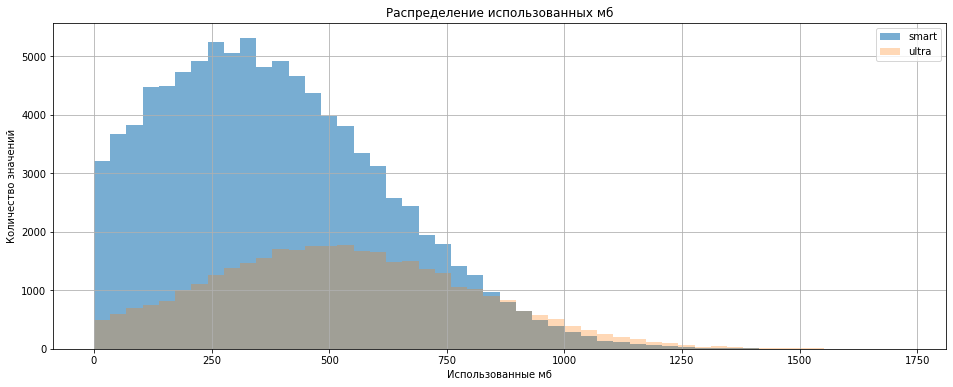

In [94]:
figure(num=None, figsize=(16, 6), facecolor='w', edgecolor='k')
internet_users.query("tariff == 'smart'")["mb_used"].hist(alpha=0.6, bins=50, range=(0.001, max(internet_users["mb_used"])))
internet_users.query("tariff == 'ultra'")["mb_used"].hist(alpha=0.3, bins=50, range=(0.001, max(internet_users["mb_used"])))
plt.title("Распределение использованных мб")
plt.xlabel("Использованные мб")
plt.ylabel("Количество значений")
plt.legend(["smart", "ultra"])
plt.grid(True)
plt.show()

Пользователи тарифа ultra чаще используют около 500 мб, пользователи тарифа smart - 260-270. Распределение тарифа ultra более плоское, без ярко выраженных пиков. Правые  хвосты распределений практически совпадают, значит примерно одинаковое количество пользователей в этих тарифах использует крайние значения количества мб.

## Вывод

- Средняя длительность разговора, использание мб и сообщений у тарифа ультра больше.
- Стандартное отклонение у тарифа ультра тоже выше, значит данные более изменчивы в этом тарифе.
- Из графиков можно сделать следующий вывод: пользователи тарифа ultra активнее пользутся услугами телекомпании.

# Шаг 4. Проверьте гипотезы<a id="id-hypothesis"></a>
--- 

> - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

> Пороговое значение alpha задайте самостоятельно.

> Поясните:
> - как вы формулировали нулевую и альтернативную гипотезы;
- какой критерий использовали для проверки гипотез и почему.

Так как нулевые гипотезы консервативные и говорят о том, что различий нет, сформулируем нулевые гипотезы следующим образом:

- Средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается;
- Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

Для проверки нулевых гипотез будем использовать стандартный p-уровень значимости .05 и гипотезу о равенстве средних 2-х генеральных совокупностей потому что пользователи 2-х разных тарифов это разные группы людей. 

Проверим нулевую гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается.

In [95]:
report

,reg_month,key,user_id,tariff,city,calls_duration,calls_count,internet_mb_used,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,extra_fee,revenue
0,2018-01-01,1,1000,ultra,Краснодар,0.0,0.0,0.0,0.0,1000,30720,3000,1950,150,1,1,0.0,1950.0
1,2018-01-01,1,1001,smart,Москва,0.0,0.0,0.0,0.0,50,15360,500,550,200,3,3,0.0,550.0
2,2018-01-01,1,1002,smart,Стерлитамак,0.0,0.0,0.0,0.0,50,15360,500,550,200,3,3,0.0,550.0
3,2018-01-01,1,1003,ultra,Москва,0.0,0.0,0.0,0.0,1000,30720,3000,1950,150,1,1,0.0,1950.0
4,2018-01-01,1,1004,ultra,Новокузнецк,0.0,0.0,0.0,0.0,1000,30720,3000,1950,150,1,1,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2018-12-01,1,1495,ultra,Иркутск,1031.0,155.0,23450.0,84.0,1000,30720,3000,1950,150,1,1,0.0,1950.0
5996,2018-12-01,1,1496,smart,Вологда,518.0,80.0,20757.0,51.0,50,15360,500,550,200,3,3,1257.0,1807.0
5997,2018-12-01,1,1497,smart,Челябинск,545.0,71.0,19940.0,17.0,50,15360,500,550,200,3,3,1135.0,1685.0
5998,2018-12-01,1,1498,smart,Владикавказ,0.0,0.0,0.0,0.0,50,15360,500,550,200,3,3,0.0,550.0


In [96]:
revenue_smart = report.query("tariff == 'smart'")["revenue"]
revenue_ultra = report.query("tariff == 'ultra'")["revenue"]

In [97]:
revenue_smart.var()

494752.5208514736

In [98]:
revenue_ultra.var()

82640.8311519062

In [99]:
st.bartlett(revenue_smart, revenue_ultra)

BartlettResult(statistic=1486.7399453317053, pvalue=0.0)

Исходя из теста Барлетта выборки не имеют одинаковую дисперсию, значит значение equal_var=False.

In [100]:
alpha = .05

In [101]:
results = st.ttest_ind(revenue_smart, revenue_ultra, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


Проверим нулевую гипотезу: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

In [102]:
report_moscow = report.query("city == 'Москва'").pivot_table(index = ["tariff", "reg_month"], values = "revenue", 
                   aggfunc="mean").reset_index()["revenue"]

In [103]:
report_other = report.query("city != 'Москва'").pivot_table(index = ["tariff", "reg_month"], values = "revenue", 
                   aggfunc="mean").reset_index()["revenue"]

In [104]:
revenue_smart_Moscow = report.query("tariff == 'smart' and city == 'Москва'")["revenue"]

In [105]:
revenue_smart_notMoscow = report.query("tariff == 'smart' and city != 'Москва'")["revenue"]

In [106]:
st.bartlett(revenue_smart_Moscow, revenue_smart_notMoscow)

BartlettResult(statistic=22.809447718758094, pvalue=1.7888416532987345e-06)

In [107]:
results = st.ttest_ind(revenue_smart_Moscow, revenue_smart_notMoscow, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0032881222202893225
Отвергаем нулевую гипотезу


## Вывод

- Для первой гипотезы вероятность получить такие различия случайно слишком маленькая, поэтому отвергаем нулевую гипотезу, а это значит, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
- Для второй гипотезы вероятность получить такие различия случайно 3%, это меньше нашего p-value значения, поэтому отвергаем нулевую гипотезу, а это значит, что выручка пользователей из Москвы отличается от выручки пользователей из остальных городов.

# Главный вывод<a id="id-conclusion"></a>

1. **Шаг 1** Открыла и первично посмотрела исходные данные, определила дальнейшие шаги по предопработке и анализу данных.


2. **Шаг 2** Провела предобработку данных - поменяла колонки типа object на тип data, где необходимо. Обнаружила 20% строк с 0 значением в колонке duration, решила никак не обрабатывать нулевые значения, чтобы не потерять часть информации. Первично посмотрела на гистограммы различных показателей, чтобы увидеть выбросы/артефаткы, таких не обнаружила. Подготовила таблицу-заготовку для расчета revenue, в которой соединила информацию из всех исходных таблиц для удобства расчетов и посчитала revenue, который оказался равен 7 582 251. Также рассчитала соотношение выручки между тарифами и оказалось, что пользователи тарифа smart приносят 52% всей выручки.


3. **Шаг 3** Посмотрела диаграммы помесячного использования тарифов smart и ultra - на диаграммах видно, что клиенты пользуются тарифом ultra более активно. По неагрегированным гистограммам можно сказать, что распределения у двух тарифов очень похожи, особенно по длительности звонков. В гистограмме количества сообщений у тарифа smart имеется более выраженный пик слева. Распределение использования интернентом у тарифа ultra более плоское без выраженных пиков.


4. **Шаг 4** Проверила 2 гипотезы: Средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается - p-уровень значимости получился слишком маленьким и я отвергла эту гипотезу. Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов - эту гипотезу я также отвергла, так как p-уровень значимости получился 3%, что меньше установленного порогового значения.


5. **Главный вывод**. Выручка по тарифу смарт выше, хотя абонплата по тарифу меньше, это может быть вызвано тем, что пакеты услуг по тарифу небольшие и пользователи часто выходят за лимиты. Этот факт подтверждается тем, что 93% выручки от продажи дополнительных услуг составляют пользователи тарифы smart. Тарифом ультра клиенты пользуются более активно, но это логично, потому что тариф включает в себя большие пакеты услуг. C точки зрения выручки тариф смарт более выгодный для компании. После проверки гипотезы можно сказать, что различия между выручкой у тарифов не являются случайными.


6. **Рекомендации** Провести дополнительные исследования по оптимальному соотношению абонплаты за тариф, платы за дополнительные услуги и объемов пакета услуг. Рассмотреть различные варианты, например, снизить абонплату за тариф, повысить плату за допуслуги и снизить пакеты услуг. С более низкой абонплатой большее количество клиентов смогу позволить себе тариф, но маленькие пакеты услуг будут приводить к тому, что пользователи будут часто выходить за лимиты, что будет приносить дополнительную выручку компании. В общем надо создать аналитический отдел и помоделировать различные ситуации:)